In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import cmocean.cm as cm
import cartopy.crs as ccrs
import os
import re
import glob
import gsw

https://data.cioospacific.ca/erddap/info/index.html?page=1&itemsPerPage=1000

link above can navigate to the metadata for all these datasets

In [2]:
fnames = os.listdir('../../../CIOOS/')

In [3]:
cleaned = []

for file in fnames:
    print(file)
    data = pd.read_csv('../../../CIOOS/' + file)
    if re.search(r'Hakai*', file):
        needed = data[['latitude','longitude','time', 'temperature','salinity', 'depth', 'pressure']]
        needed = needed.rename(columns={"temperature": "TEMPS901", "salinity":"PSALST01"}).tail(-1)
    elif re.search(r'IOS_BOT*', file):
        needed = data[['latitude','longitude','time', 'TEMPS901','PSALST01', 'depth', "sea_water_pressure"]].tail(-1)
        needed = needed.rename(columns={'sea_water_pressure': 'pressure'})
    elif re.search(r'IOS_CTD*', file):
        needed = data[['latitude','longitude','time', 'TEMPS901','PSALST01', 'depth', 'sea_water_pressure']].tail(-1)
        needed = needed.rename(columns={'sea_water_pressure': 'pressure'})
    else:
        print('no filename match for ' + file)
    needed['SA'] = gsw.conversions.SA_from_SP(needed['PSALST01'].values, needed['pressure'].values, needed['longitude'].values, needed['latitude'].values)
    cleaned = cleaned + [needed]

HakaiWaterPropertiesInstrumentProfileProvisional_catalogue_hakai_org.csv


/tmp/ipykernel_1391604/3236286627.py:5: DtypeWarning: Columns (11,12,13,14,23,24,27,30,33,36,39,41,42,44,45,47,48,50,51,54,57,60,63) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../../../CIOOS/' + file)


IOS_BOT_Profiles_data_cioospacific_ca_01.csv
IOS_CTD_Profiles_data_cioospacific_ca_02.csv
HakaiWaterPropertiesInstrumentProfileResearch_catalogue_hakai_org.csv
IOS_CTD_Profiles_data_cioospacific_ca.csv
IOS_BOT_Profiles_data_cioospacific_ca_02.csv
IOS_CTD_Profiles_data_cioospacific_ca_01.csv
IOS_BOT_Profiles_data_cioospacific_ca.csv


/tmp/ipykernel_1391604/3236286627.py:5: DtypeWarning: Columns (10,11,12,13,22,23,24,25,26,27,29,30,32,33,34,35,36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../../../CIOOS/' + file)
/tmp/ipykernel_1391604/3236286627.py:5: DtypeWarning: Columns (13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../../../CIOOS/' + file)


In [4]:
cleaned[2]

,latitude,longitude,time,TEMPS901,PSALST01,depth,pressure,SA
1,49.342335,-123.47767,2009-02-27T20:18:03Z,6.2169,27.1951,5.0565267,5.1,27.327277
2,49.342335,-123.47767,2009-02-27T20:18:03Z,7.7056,29.6999,29.742477,30.0,29.843309
3,49.342335,-123.47767,2009-02-27T20:18:03Z,7.7227,29.7218,30.733818,31.0,29.865301
4,49.342335,-123.47767,2009-02-27T20:18:03Z,7.7602,29.7787,31.725155,32.0,29.922462
5,49.342335,-123.47767,2009-02-27T20:18:03Z,7.7822,29.81,32.716488,33.0,29.953899
...,...,...,...,...,...,...,...,...
3285,49.676666,-123.17333,2023-03-05T14:04:39Z,7.7059,30.0944,20.8,21.0,30.240401
3286,49.676666,-123.17333,2023-03-05T14:04:39Z,7.7205,30.105,21.8,22.0,30.250987
3287,49.676666,-123.17333,2023-03-05T14:04:39Z,7.7337,30.1134,22.8,23.0,30.259362
3288,49.676666,-123.17333,2023-03-05T14:04:39Z,7.4744,29.8829,11.9,12.0,30.027972


In [5]:
all_data = pd.concat([cleaned[0].tail(-1), cleaned[1].tail(-1), cleaned[2].tail(-1), cleaned[3].tail(-1), cleaned[4].tail(-1), cleaned[5].tail(-1), cleaned[6].tail(-1), cleaned[7].tail(-1)], ignore_index=True)
all_data['year'] = [i.split('-')[0] for i in all_data['time']]

In [6]:
# units = cleaned[1].head(1)
# units

In [7]:
years = np.arange(2007, 2024)
yearly_data = []
for y in years:
    data_year  = pd.concat([all_data[all_data['year'] == str(y)]], ignore_index=True)
    data_year = data_year.drop(columns=['year'])
    data_year.to_csv('CIOOS_' + str(y) + '.csv')

In [8]:
all_out = all_data.drop(columns=['year'])
all_out = all_out.rename(columns={"temperature": "TEMPS901", "PSALST01":"SA"})
all_out.to_csv('CIOOS_2007_2023.csv',index=False)

## Look at other csv for the units?

In [9]:
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
# the mask is 1 where there is water, we want the opposite.  The meshmask has an extra dimension, hence the [0]
tmask = 1 - mesh.tmask[0][0,:,:]

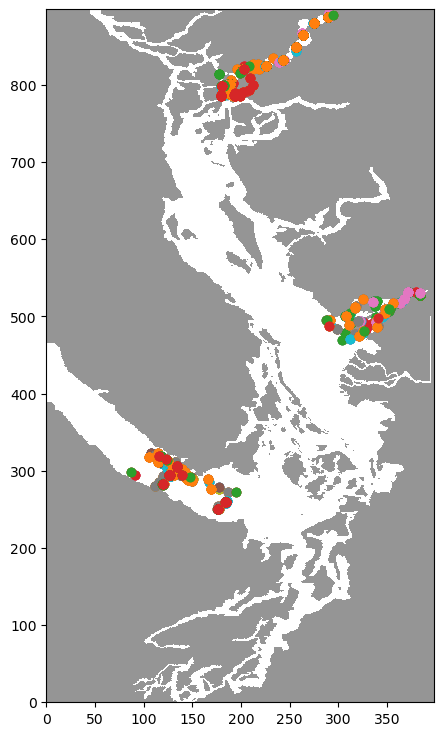

In [10]:
fnames_obsmodel = glob.glob('ObsModel_*.csv')

cmap = 'Greys'
fig, ax = plt.subplots(1, 1, figsize=(5, 9))
colours = ax.pcolormesh(tmask*0.5, vmin=0, vmax=1, cmap=cmap)

for file in fnames_obsmodel:
    comparisons = pd.read_csv(file)
    ax.scatter(comparisons['i'][comparisons['Z'] <= 5], comparisons['j'][comparisons['Z'] <= 5], label=file)
    # ax.scatter(comparisons['i'], comparisons['j'], alpha=0.5)

# plt.legend()

In [ ]:
# for file in fnames:
#     print(file)
#     data = pd.read_csv('../../../CIOOS/' + file)
#     if re.search(r'Hakai*', file):
#         needed = data[['latitude','longitude','time', 'temperature','salinity', 'depth', 'pressure']]
#         needed = needed.rename(columns={"temperature": "TEMPS901", "salinity":"PSALST01"}).tail(-1)
#     elif re.search(r'IOS_BOT*', file):
#         needed = data[['latitude','longitude','time', 'TEMPS901','PSALST01', 'depth', "sea_water_pressure"]].tail(-1)
#         needed = needed.rename(columns={'sea_water_pressure': 'pressure'})
#     elif re.search(r'IOS_CTD*', file):
#         needed = data[['latitude','longitude','time', 'TEMPS901','PSALST01', 'depth', 'sea_water_pressure']].tail(-1)
#         needed = needed.rename(columns={'sea_water_pressure': 'pressure'})
#     else:
#         print('no filename match for ' + file)
#     needed['SA'] = gsw.conversions.SA_from_SP(needed['PSALST01'].values, needed['pressure'].values, needed['longitude'].values, needed['latitude'].values)
#     cleaned = cleaned + [needed]

In [45]:
fnum = 7
print(fnames[fnum])

IOS_BOT_Profiles_data_cioospacific_ca.csv


In [46]:
pd.read_csv('../../../CIOOS/' + fnames[fnum]).drop(0).time.min()

'2009-09-18T03:48:10Z'

In [47]:
pd.read_csv('../../../CIOOS/' + fnames[fnum]).drop(0).time.max()

'2023-03-03T07:44:56Z'